In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
load_path = 'processed_data/data_2006_2023.csv'

In [3]:
load_data = pd.read_csv(load_path)

Since we are dealing wih time serie data, let's check for staionary

In [4]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [5]:
adf_test(load_data["loadConsumption"])

ADF Statistic: -27.204566436886566
p-value: 0.0
Data is stationary


In [6]:
load_data["dateime"] = pd.to_datetime(load_data["datetime"])


In [7]:
load_data = load_data.set_index('datetime')
load_data.index = pd.to_datetime(load_data.index)

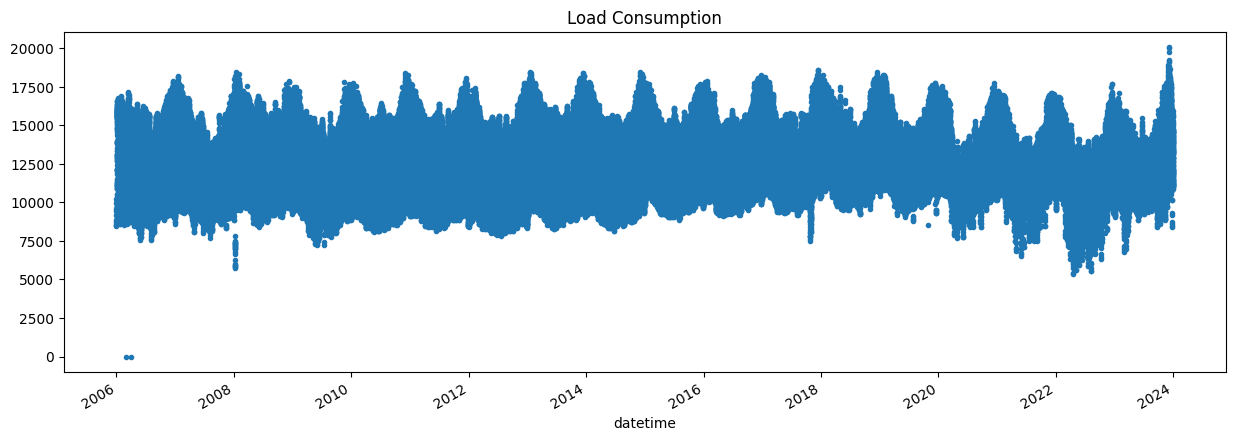

In [8]:
load_data['loadConsumption'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Load Consumption')
plt.show()

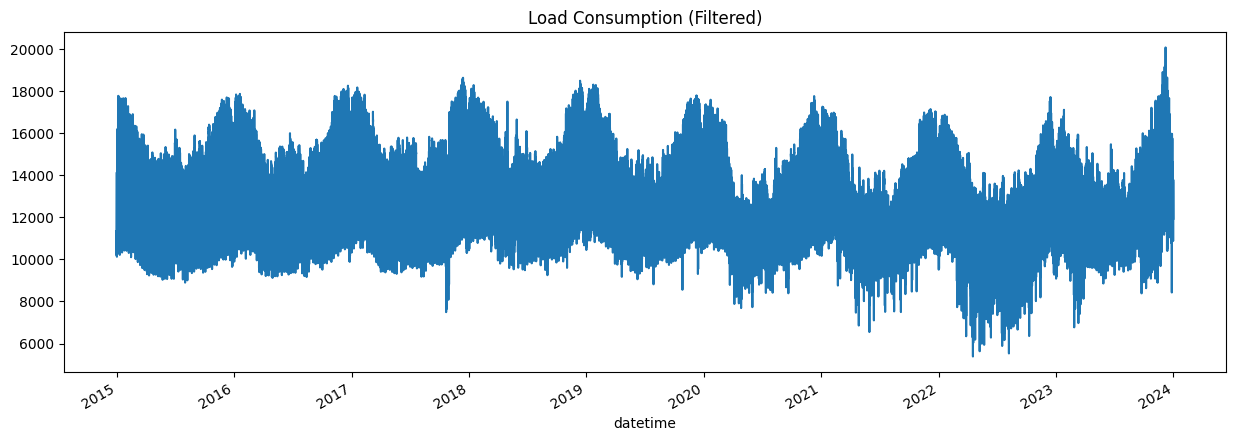

In [9]:
start_date = '2015-01-01'
end_date = '2023-12-31'

filtered_data = load_data.loc[start_date:end_date]
filtered_data['loadConsumption'].plot(
    style='-',
    figsize=(15, 5),
    color=color_pal[0],
    title='Load Consumption (Filtered)'
)
plt.show()

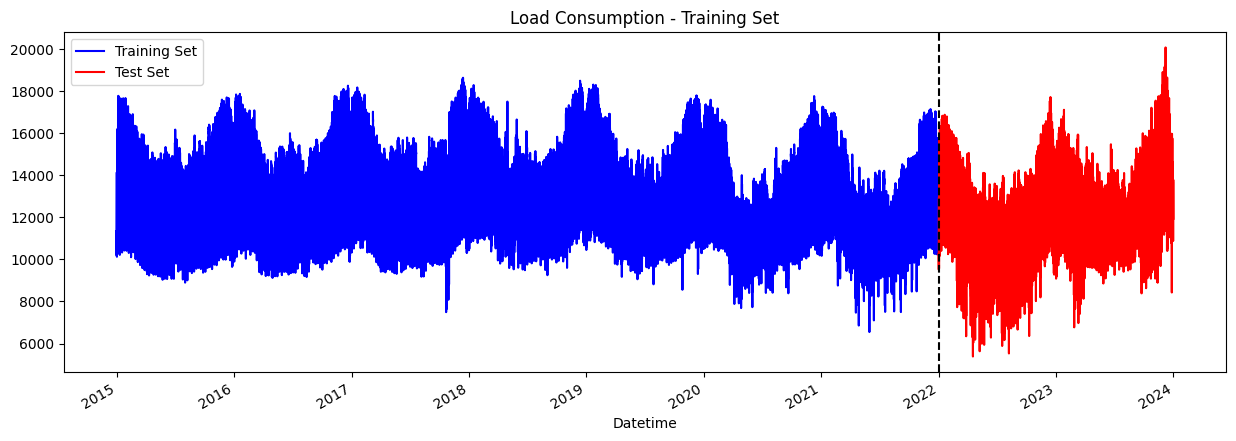

In [10]:
train = filtered_data.loc[filtered_data.index < '01-01-2022']
test = filtered_data.loc[filtered_data.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train['loadConsumption'].plot(ax=ax, label='Training Set', color='blue')
test['loadConsumption'].plot(ax=ax, label='Test Set', color='red')
ax.axvline('01-01-2022', color='black', ls='--')
ax.set_title('Load Consumption - Training Set')
ax.set_xlabel('Datetime')
ax.legend(['Training Set', 'Test Set'])
plt.show()


filtered_data['loadConsumption'].loc[(filtered_data.index > '01-01-2017') & (filtered_data.index < '01-08-2017')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


## Create Features

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(load_data)

In [12]:
df.head()

,loadConsumption,date,Hour,Year,dateime,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,,
2005-12-31 23:00:00,10215.0,2006-01-01,0,2006,2005-12-31 23:00:00,5,4,12,365,31,52
2006-01-01 00:00:00,9979.0,2006-01-01,1,2006,2006-01-01 00:00:00,6,1,1,1,1,52
2006-01-01 01:00:00,9460.0,2006-01-01,2,2006,2006-01-01 01:00:00,6,1,1,1,1,52
2006-01-01 02:00:00,8833.0,2006-01-01,3,2006,2006-01-01 02:00:00,6,1,1,1,1,52
2006-01-01 03:00:00,8525.0,2006-01-01,4,2006,2006-01-01 03:00:00,6,1,1,1,1,52


## Visualize our Feature / Target Relationship


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


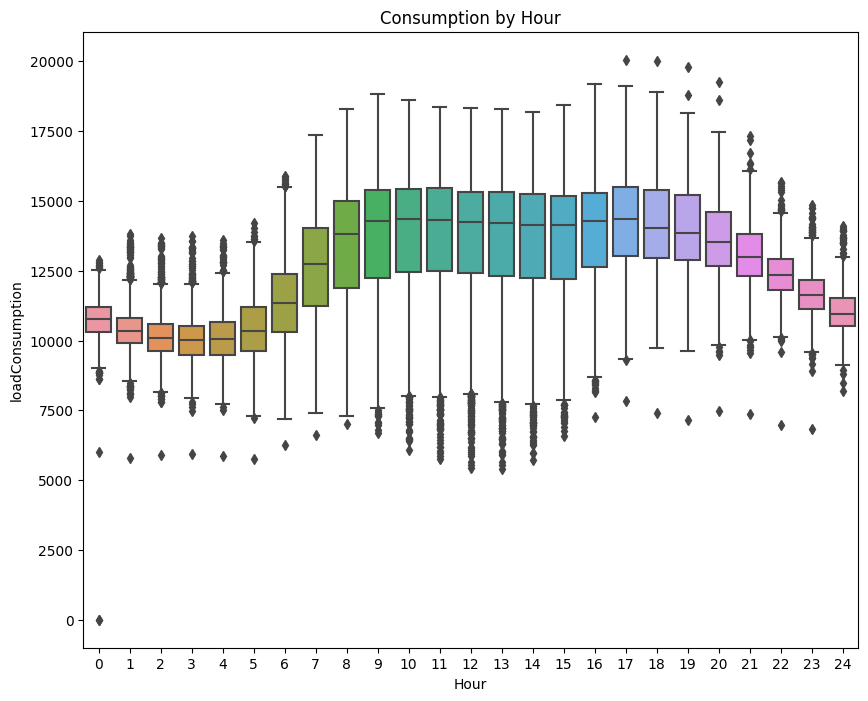

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='loadConsumption')
ax.set_title('Consumption by Hour')
plt.show()

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


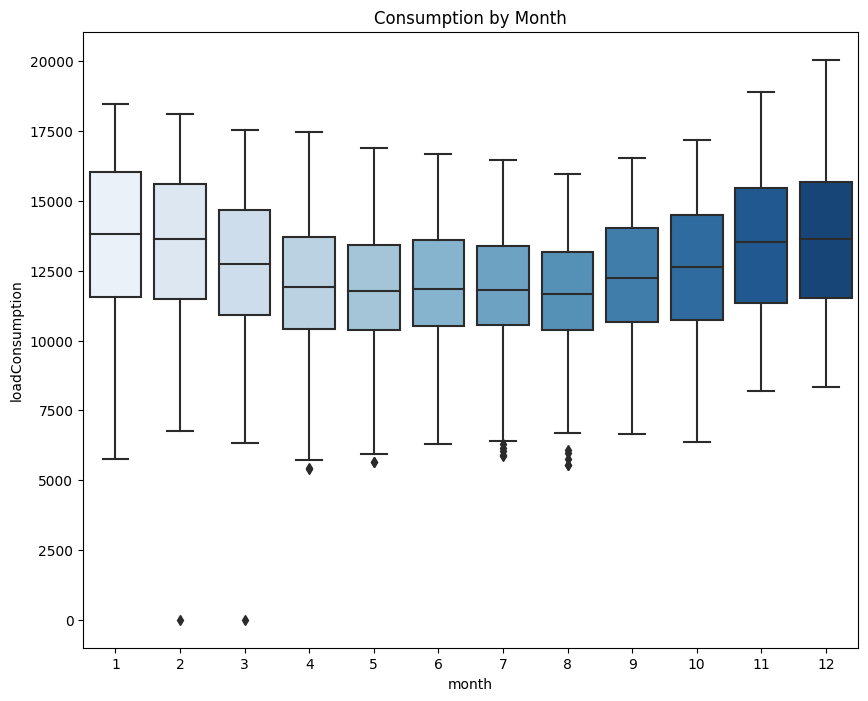

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='loadConsumption', palette='Blues')
ax.set_title('Consumption by Month')
plt.show()

It is clear the consumption peak is during winter in the Netherland

## Create simple Model

In [15]:
df.columns

Index(['loadConsumption', 'date', 'Hour', 'Year', 'dateime', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [16]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Hour','Year','dayofweek','month', 'weekofyear']
TARGET = 'loadConsumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.05)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:12352.15786	validation_1-rmse:11485.37866
[100]	validation_0-rmse:775.01397	validation_1-rmse:1353.95488
[200]	validation_0-rmse:674.71494	validation_1-rmse:1290.02761
[300]	validation_0-rmse:639.04337	validation_1-rmse:1256.67149
[400]	validation_0-rmse:618.72025	validation_1-rmse:1245.80959
[500]	validation_0-rmse:605.00167	validation_1-rmse:1238.53700
[600]	validation_0-rmse:590.99465	validation_1-rmse:1231.25123
[700]	validation_0-rmse:583.37830	validation_1-rmse:1225.64010
[800]	validation_0-rmse:575.99558	validation_1-rmse:1222.96265
[900]	validation_0-rmse:569.62956	validation_1-rmse:1222.39579
[1000]	validation_0-rmse:564.19506	validation_1-rmse:1221.38536
[1100]	validation_0-rmse:559.14933	validation_1-rmse:1219.40868
[1200]	validation_0-rmse:555.03461	validation_1-rmse:1215.38594
[1300]	validation_0-rmse:551.80385	validation_1-rmse:1213.83199
[1388]	validation_0-rmse:549.25414	validation_1-rmse:1214.09035


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
r2 = r2_score(y_test, reg.predict(X_test))

# Display the results
rmse, mse, mae, r2


(1213.805751889927, 1473324.403321071, 905.4392196909964, 0.6251549705887498)

## Feature Importance

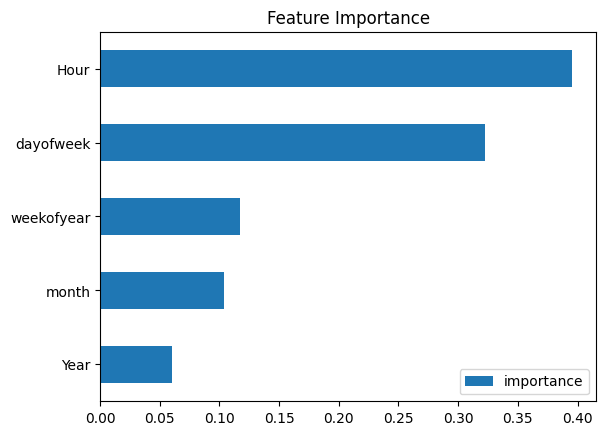

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Feature engineering

- These features capture trends, seasonality, and dependencies in time-series data.
- They help XGBoost learn temporal relationships effectively.

In [20]:
# Adding Lag Features
train['lag_1'] = train['loadConsumption'].shift(1)
train['lag_7'] = train['loadConsumption'].shift(7)
train['lag_30'] = train['loadConsumption'].shift(30)

test['lag_1'] = test['loadConsumption'].shift(1)
test['lag_7'] = test['loadConsumption'].shift(7)
test['lag_30'] = test['loadConsumption'].shift(30)

# Adding Rolling Statistics
train['rolling_mean_7'] = train['loadConsumption'].rolling(window=7).mean()
train['rolling_std_7'] = train['loadConsumption'].rolling(window=7).std()

test['rolling_mean_7'] = test['loadConsumption'].rolling(window=7).mean()
test['rolling_std_7'] = test['loadConsumption'].rolling(window=7).std()

# Adding Expanding Window Statistics
train['expanding_mean'] = train['loadConsumption'].expanding().mean()
test['expanding_mean'] = test['loadConsumption'].expanding().mean()


In [21]:
FEATURES = [
    'Hour', 'Year', 'dayofweek', 'quarter', 'month',
    'lag_1', 'lag_7', 'lag_30',  # Lag features
    'rolling_mean_7', 'rolling_std_7',  # Rolling window statistics
    'expanding_mean'  # Expanding mean
]

TARGET = 'loadConsumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


### Hyper-tuned model

In [22]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,  
    early_stopping_rounds=100,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,  
    subsample=0.8,  # Helps generalization
    colsample_bytree=0.8,  # Feature selection per tree
    min_child_weight=5  
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:11704.45262	validation_1-rmse:10883.93477
[100]	validation_0-rmse:260.95402	validation_1-rmse:420.05133
[200]	validation_0-rmse:226.30687	validation_1-rmse:382.58434
[300]	validation_0-rmse:213.01674	validation_1-rmse:370.55880
[400]	validation_0-rmse:204.93753	validation_1-rmse:361.19991
[500]	validation_0-rmse:197.53834	validation_1-rmse:354.69127
[600]	validation_0-rmse:191.70289	validation_1-rmse:348.30316
[700]	validation_0-rmse:187.59570	validation_1-rmse:344.19771
[800]	validation_0-rmse:183.93906	validation_1-rmse:341.33159
[900]	validation_0-rmse:180.82433	validation_1-rmse:337.35073
[999]	validation_0-rmse:178.16013	validation_1-rmse:335.14374


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
if 'reg' in locals() and 'X_test' in locals() and 'y_test' in locals():
    # Generate predictions
    y_pred = reg.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

    # Display results
    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "MAPE": mape
    }

In [29]:
metrics

{'RMSE': 335.0082900501303,
 'MSE': 112230.55440231225,
 'MAE': 230.15829805079954,
 'R²': 0.9714461625892123,
 'MAPE': 2.026159371060401}

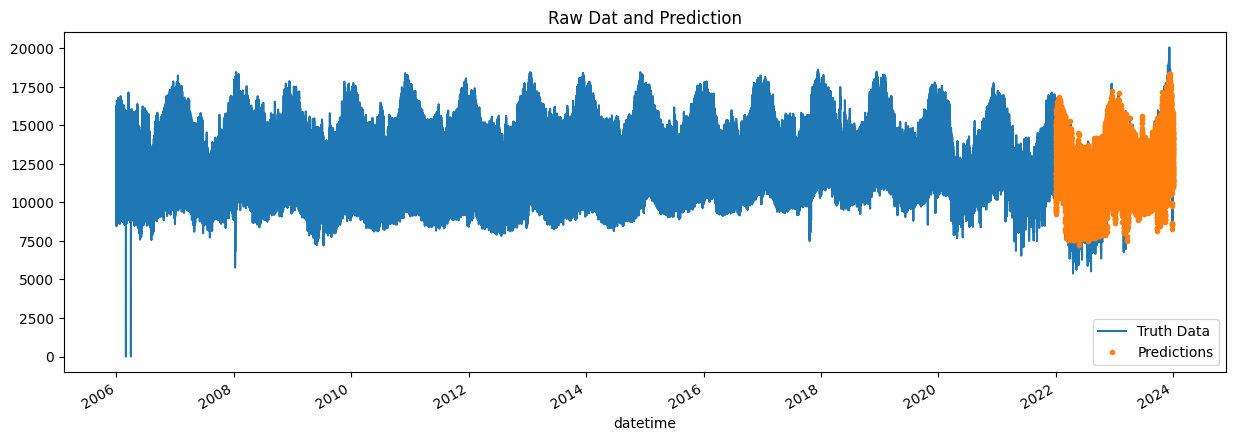

In [30]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['loadConsumption']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

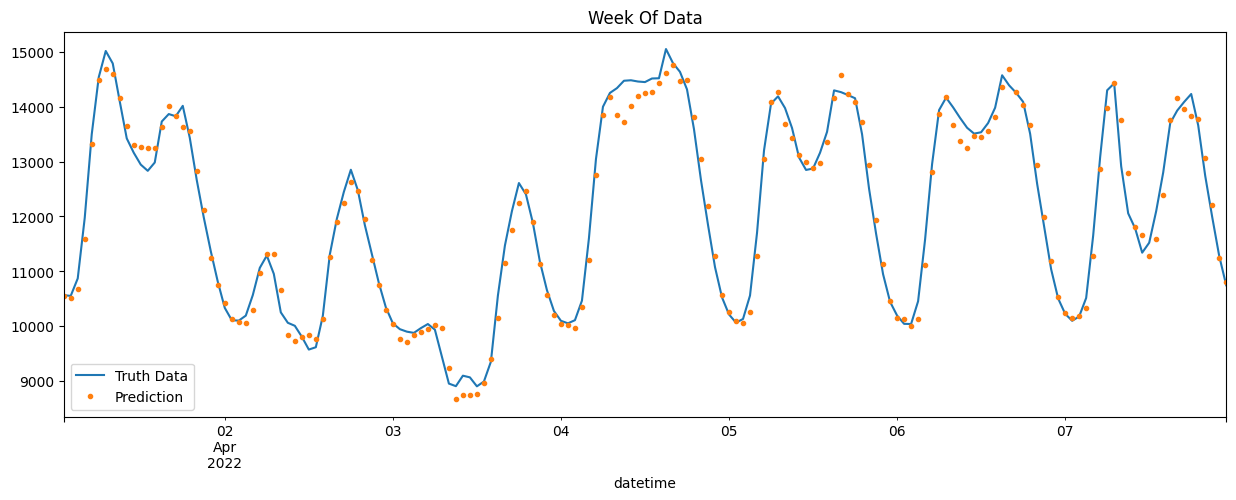

In [31]:
ax = df.loc[(df.index > '04-01-2022') & (df.index < '04-08-2022')]['loadConsumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2022') & (df.index < '04-08-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

RMSE-score

In [32]:
score = np.sqrt(mean_squared_error(test['loadConsumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 335.01


look at the worst and best predictions (day prediction)

In [33]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-12-07    880.304214
2022-08-07    827.318088
2022-04-17    705.489178
2022-07-17    669.350013
2022-05-08    654.186365
2022-05-22    651.697404
2022-05-15    601.283229
2023-12-04    582.903942
2022-10-09    573.885662
2022-07-24    568.722697
Name: error, dtype: float64

#### check for overfiiting

In [34]:
train_rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


Train RMSE: 178.49
Test RMSE: 335.01


-> train RMSE < test RMSE, overfitting is likely.

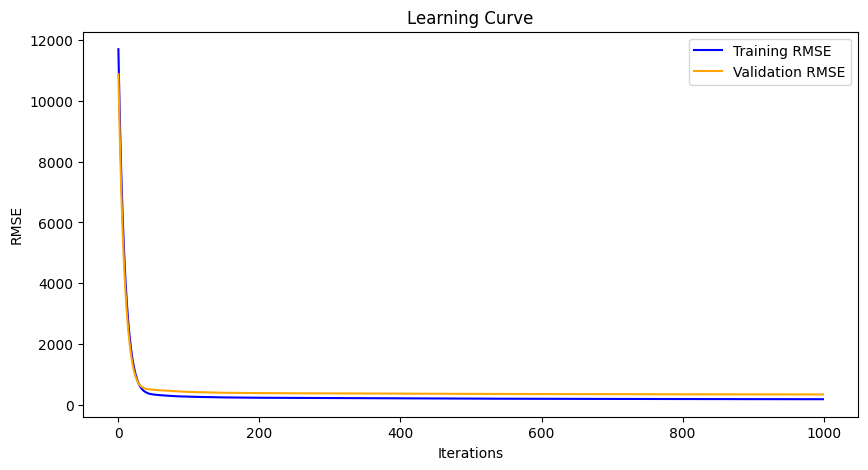

In [35]:
## plot the learning curve

results = reg.evals_result()
train_rmse = results['validation_0']['rmse']
test_rmse = results['validation_1']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE', color='blue')
plt.plot(test_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()


Both lines decrease and plateau together, the model is well-trained

In [36]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.5,  # Use 50% of the data for each tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    reg_alpha=0.1,  # L1 regularization (Lasso)
    reg_lambda=0.1,  # L2 regularization (Ridge)
)

In [37]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:1933.67789	validation_1-rmse:2086.96105
[100]	validation_0-rmse:222.94515	validation_1-rmse:393.00489
[200]	validation_0-rmse:188.52404	validation_1-rmse:343.09872
[300]	validation_0-rmse:175.26957	validation_1-rmse:331.27044
[400]	validation_0-rmse:167.03728	validation_1-rmse:323.47405
[500]	validation_0-rmse:159.26126	validation_1-rmse:319.87517
[600]	validation_0-rmse:154.29412	validation_1-rmse:316.90042
[700]	validation_0-rmse:149.92066	validation_1-rmse:316.47358
[800]	validation_0-rmse:145.98825	validation_1-rmse:314.86881
[900]	validation_0-rmse:142.33675	validation_1-rmse:314.74806
[999]	validation_0-rmse:138.92175	validation_1-rmse:313.99093


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
# Ensure the model has been trained and required variables are defined
if 'reg' in locals() and 'X_test' in locals() and 'y_test' in locals():
    # Generate predictions
    y_pred = reg.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

    # Display results
    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "MAPE": mape
    }

metrics

{'RMSE': 313.9909343034218,
 'MSE': 98590.30682473574,
 'MAE': 210.68534436454647,
 'R²': 0.9749165313639832,
 'MAPE': 1.8657212807954964}

In [40]:
train_rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


Train RMSE: 138.92
Test RMSE: 313.99


In [41]:
reg = xgb.XGBRegressor(
    booster='dart',  # DART (Dropout boosting)
    rate_drop=0.3,  # More dropout for faster training
    skip_drop=0.2,  # Increase probability of skipping dropout
    max_depth=2,  # Keep low complexity
    learning_rate=0.1,  # Increase learning rate for faster convergence
    n_estimators=300,  # Reduce number of boosting rounds
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,  # L1 regularization (lower to speed up)
    reg_lambda=1,  # L2 regularization
    gamma=5,  # Lower split constraint for speed
    early_stopping_rounds=50  # Stop when no improvement
)


In [42]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:1852.37484	validation_1-rmse:2007.72137
[100]	validation_0-rmse:503.20115	validation_1-rmse:698.18715
[200]	validation_0-rmse:421.75442	validation_1-rmse:586.94255
[299]	validation_0-rmse:375.96907	validation_1-rmse:537.30511


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
# Ensure the model has been trained and required variables are defined
if 'reg' in locals() and 'X_test' in locals() and 'y_test' in locals():
    # Generate predictions
    y_pred = reg.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

    # Display results
    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "MAPE": mape
    }

metrics

{'RMSE': 539.6152504053782,
 'MSE': 291184.618470059,
 'MAE': 368.9439572957101,
 'R²': 0.9259164467591278,
 'MAPE': 3.348810787985551}